In [44]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from gerrychain import Graph, Partition

import pandas as pd
import geopandas as gpd
import maup
import time

maup.progress.enabled = True

In [45]:
def load_data(file_name):
    start_time = time.time()
    df = gpd.read_file(file_name)
    end_time = time.time()
    print(f'The time to import {file_name} is: {(end_time - start_time) / 60} mins')

    return df

In [46]:
population_df = load_data('./data/co_pl2020_vtd/co_pl2020_vtd.shp')

The time to import ./data/co_pl2020_vtd/co_pl2020_vtd.shp is: 1.246740182240804 mins


In [47]:
election_df = load_data('./data/elections/co_vest_20/co_vest_20.shp')

The time to import ./data/elections/co_vest_20/co_vest_20.shp is: 0.04330414930979411 mins


In [68]:
cong_df = load_data('./data/co_cong_adopted_2021/')

The time to import ./data/co_cong_adopted_2021/ is: 0.0017311533292134603 mins


In [69]:
cong_df.shape

(8, 6)

In [70]:
print(population_df.columns)
print(election_df.columns)
print(cong_df.columns)

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'GEOID20', 'VTDI20', 'NAME20',
       'NAMELSAD20', 'LSAD20', 'MTFCC20', 'FUNCSTAT20',
       ...
       'P0050002', 'P0050003', 'P0050004', 'P0050005', 'P0050006', 'P0050007',
       'P0050008', 'P0050009', 'P0050010', 'geometry'],
      dtype='object', length=348)
Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAME', 'PRECINCT', 'G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PRECBLA', 'G20PREUWES',
       'G20PREOOTH', 'G20USSDHIC', 'G20USSRGAR', 'G20USSLDOA', 'G20USSODOY',
       'G20USSOEVA', 'G20USSOWRI', 'geometry', 'P0020001', 'P0020002',
       'P0020003', 'P0020004', 'P0020005', 'P0020006', 'P0020007', 'P0020008',
       'P0020009', 'P0020010', 'P0020011', 'P0020012', 'P0020013', 'P0020014',
       'P0020015', 'P0020016', 'P0020017', 'P0020018', 'P0020019', 'P0020020',
       'P0020021', 'P0020022', 'P0020023', 'P0020024', 'P0020025', 'P0020026',
       'P0020027', 'P0020028', 'P0020029', 'P0020030', 'P0020031', 'P00200

In [71]:
district_col_name = "District"

In [53]:
election_crs = election_df.estimate_utm_crs()

election_df = election_df.to_crs(election_crs)
population_df = population_df.to_crs(election_crs)
cong_df = cong_df.to_crs(election_crs)

In [54]:
blocks_to_precincts_assignment = maup.assign(population_df.geometry, election_df.geometry)

100%|██████████████████████████████████████| 3215/3215 [00:10<00:00, 305.76it/s]


In [78]:
pop_column_names = ['P0020001', 'P0020002', 'P0020005', 'P0020006', 'P0020007',
                    'P0020008', 'P0020009', 'P0020010', 'P0020011']

In [79]:
for name in pop_column_names:
    election_df[name] = population_df[name].groupby(blocks_to_precincts_assignment).sum()

In [57]:
print(population_df['P0020001'].sum())
print(election_df['P0020001'].sum())

5773714
5773714.0


In [58]:
print(maup.doctor(election_df))

100%|██████████████████████████████████████| 3215/3215 [00:07<00:00, 453.01it/s]


There are 1705 overlaps.
There are 3584 holes.
There are some invalid geometries.
False


In [59]:
repaired_election_df = maup.smart_repair(election_df)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████| 14935/14935 [00:13<00:00, 1097.58it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


Gaps to simplify: 5451it [49:28,  1.84it/s]                                     
Gaps to fill: 100%|███████████████████████████| 595/595 [06:10<00:00,  1.61it/s]


In [60]:
print(maup.doctor(repaired_election_df))

100%|██████████████████████████████████████| 3215/3215 [00:06<00:00, 475.72it/s]


True


In [73]:
print(maup.doctor(cong_df))

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 42.67it/s]


There are 5 holes.
False


In [74]:
repaired_cong_df = maup.smart_repair(cong_df)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 241.99it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 100%|███████████████████████████| 5/5 [00:02<00:00,  2.18it/s]
Gaps to fill: 0it [00:00, ?it/s]


In [75]:
print(maup.doctor(repaired_cong_df))

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 43.19it/s]


True


In [81]:
precincts_to_districts_assignment = maup.assign(repaired_election_df.geometry, repaired_cong_df.geometry)
repaired_election_df["CD"] = precincts_to_districts_assignment

100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  7.73it/s]


In [82]:
print(set(repaired_election_df["CD"]))
for precinct_index in range(len(election_df)):
    repaired_election_df.at[precinct_index, "CD"] = cong_df.at[repaired_election_df.at[precinct_index, "CD"], district_col_name]
print(set(cong_df[district_col_name]))
print(set(repaired_election_df["CD"]))

{0, 1, 2, 3, 4, 5, 6, 7}
{1, 2, 3, 4, 5, 6, 7, 8}
{1, 2, 3, 4, 5, 6, 7, 8}


In [84]:
repaired_election_df.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAME', 'PRECINCT', 'G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PRECBLA', 'G20PREUWES',
       'G20PREOOTH', 'G20USSDHIC', 'G20USSRGAR', 'G20USSLDOA', 'G20USSODOY',
       'G20USSOEVA', 'G20USSOWRI', 'geometry', 'P0020001', 'P0020002',
       'P0020003', 'P0020004', 'P0020005', 'P0020006', 'P0020007', 'P0020008',
       'P0020009', 'P0020010', 'P0020011', 'P0020012', 'P0020013', 'P0020014',
       'P0020015', 'P0020016', 'P0020017', 'P0020018', 'P0020019', 'P0020020',
       'P0020021', 'P0020022', 'P0020023', 'P0020024', 'P0020025', 'P0020026',
       'P0020027', 'P0020028', 'P0020029', 'P0020030', 'P0020031', 'P0020032',
       'P0020033', 'P0020034', 'P0020035', 'P0020036', 'P0020037', 'P0020038',
       'P0020039', 'P0020040', 'P0020041', 'P0020042', 'P0020043', 'P0020044',
       'P0020045', 'P0020046', 'P0020047', 'P0020048', 'P0020049', 'P0020050',
       'P0020051', 'P0020052', 'P0020053', 'P0020054', 'P0020055', 'P0

In [85]:
rename_dict = {'P0020001': 'TOTPOP',
               'P0020002': 'HISP',
               'P0020005': 'NH_WHITE',
               'P0020006': 'NH_BLACK',
               'P0020007': 'NH_AMIN',
               'P0020008': 'NH_ASIAN',
               'P0020009': 'NH_NHPI',
               'P0020010': 'NH_OTHER',
               'P0020011': 'NH_2MORE',
               'G20PREDBID': 'G20PRED',
               'G20PRERTRU': 'G20PRER',
               'G20USSDHIC': 'G20USSD', 
               'G20USSRGAR': 'G20USSR'}

In [88]:
clean_election_df = repaired_election_df.rename(columns=rename_dict)
clean_election_df.drop(columns=[
       'G20PRELJOR', 'G20PREGHAW', 'G20PRECBLA', 'G20PREUWES',
       'G20PREOOTH', 'G20USSLDOA','G20USSODOY','G20USSOEVA',
       'G20USSOWRI', 
       'P0020003', 'P0020004', 'P0020012', 'P0020013', 'P0020014',
       'P0020015', 'P0020016', 'P0020017', 'P0020018', 'P0020019', 'P0020020',
       'P0020021', 'P0020022', 'P0020023', 'P0020024', 'P0020025', 'P0020026',
       'P0020027', 'P0020028', 'P0020029', 'P0020030', 'P0020031', 'P0020032',
       'P0020033', 'P0020034', 'P0020035', 'P0020036', 'P0020037', 'P0020038',
       'P0020039', 'P0020040', 'P0020041', 'P0020042', 'P0020043', 'P0020044',
       'P0020045', 'P0020046', 'P0020047', 'P0020048', 'P0020049', 'P0020050',
       'P0020051', 'P0020052', 'P0020053', 'P0020054', 'P0020055', 'P0020056',
       'P0020057', 'P0020058', 'P0020059', 'P0020060', 'P0020061', 'P0020062',
       'P0020063', 'P0020064', 'P0020065', 'P0020066', 'P0020067', 'P0020068',
       'P0020069', 'P0020070', 'P0020071', 'P0020072', 'P0020073'], inplace=True)

In [89]:
clean_election_df

,STATEFP,COUNTYFP,VTDST,NAME,PRECINCT,G20PRED,G20PRER,G20USSD,G20USSR,geometry,TOTPOP,HISP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,NH_NHPI,NH_OTHER,NH_2MORE,CD
0,08,001,001226,Adams 226,6253001226,60,128,60,131,"POLYGON ((527454.509 4424739.321, 527457.779 4...",368.0,141.0,204.0,0.0,1.0,12.0,0.0,0.0,10.0,8
1,08,001,001092,Adams 092,7243401092,653,579,649,572,"POLYGON ((502806.421 4418210.473, 502809.065 4...",2349.0,796.0,1304.0,17.0,14.0,60.0,7.0,13.0,138.0,8
2,08,001,001089,Adams 089,7243101089,666,454,645,469,"POLYGON ((504093.002 4419009.995, 504233.723 4...",2369.0,651.0,1360.0,68.0,17.0,128.0,1.0,17.0,127.0,8
3,08,001,001087,Adams 087,7243401087,690,467,668,475,"POLYGON ((501149.558 4418223.587, 501149.558 4...",3273.0,972.0,1884.0,87.0,27.0,103.0,12.0,26.0,162.0,8
4,08,001,001088,Adams 088,7243101088,706,516,695,543,"POLYGON ((503472.879 4419270.698, 503469.932 4...",1880.0,406.0,1274.0,26.0,15.0,80.0,0.0,4.0,75.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3210,08,001,001003,Adams 003,7213201003,646,222,622,227,"POLYGON ((499536.562 4406566.492, 499477.256 4...",2966.0,792.0,1793.0,48.0,19.0,184.0,8.0,2.0,120.0,8
3211,08,087,087001,Morgan 001,4016544001,166,773,163,777,"POLYGON ((572293.044 4455849.658, 572282.570 4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
3212,08,087,087018,Morgan 018,4016544018,168,735,164,740,"POLYGON ((585138.310 4428351.576, 585128.407 4...",3237.0,642.0,2422.0,21.0,12.0,14.0,0.0,12.0,114.0,4
3213,08,087,087004,Morgan 004,4016544004,170,687,155,696,"POLYGON ((603073.265 4428600.299, 603038.696 4...",1475.0,387.0,1032.0,10.0,5.0,6.0,1.0,7.0,27.0,4


<Axes: >

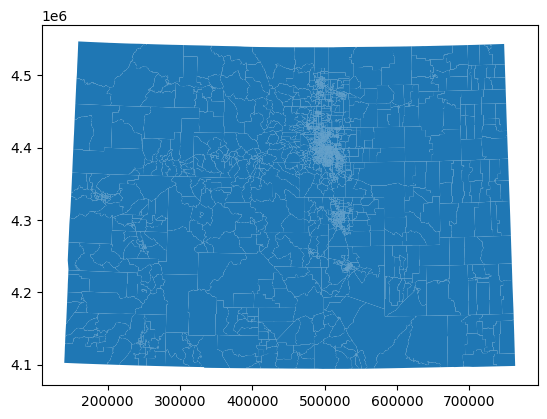

In [90]:
clean_election_df.plot()

In [93]:
pop_vals = [clean_election_df.loc[clean_election_df["CD"] == n, "TOTPOP"].sum() for n in range(1, 9)]
pop_vals

[720658.0,
 725183.0,
 725508.0,
 722793.0,
 722130.0,
 722266.0,
 722425.0,
 712751.0]

In [95]:
clean_election_df.to_file("./data/cleaned/CO.shp")
shp_file = gpd.read_file("./data/cleaned/CO.shp")
shp_file.to_file('./data/cleaned/CO.geojson', driver='GeoJSON')